In [1]:
import pandas as pd
import glob
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import itertools
import warnings
warnings.filterwarnings('ignore')
from utils.data_proc import tab_data
from utils.data_proc import dataframe_column_adj

def recall_from_roc(x, threshold):
    filt_array = np.array(x['precision'])>threshold
    if sum(filt_array)>0:
        return max(np.array(x['recall'])[filt_array])
    else:
        return 0.
    
def energy_from_roc(x, threshold):
    filt_array = np.array(x['precision'])>threshold
    if sum(filt_array)>0:
        return (np.array(x['energy_after_threshold'])[filt_array]).max()
    else:
        return 0.

PATH = '../data/for_analysis/'

In [2]:
files = glob.glob(PATH + '*.json')

In [3]:
result_table = []
for file in files:
    result_table.append(tab_data(file))
result_table = pd.concat(result_table)

In [4]:
result_table =  dataframe_column_adj(result_table)

In [5]:
best_filters = result_table.groupby(['particle', 'energy', 'image', 'filter']).agg({'f1':'max'}).reset_index()

[None, None]

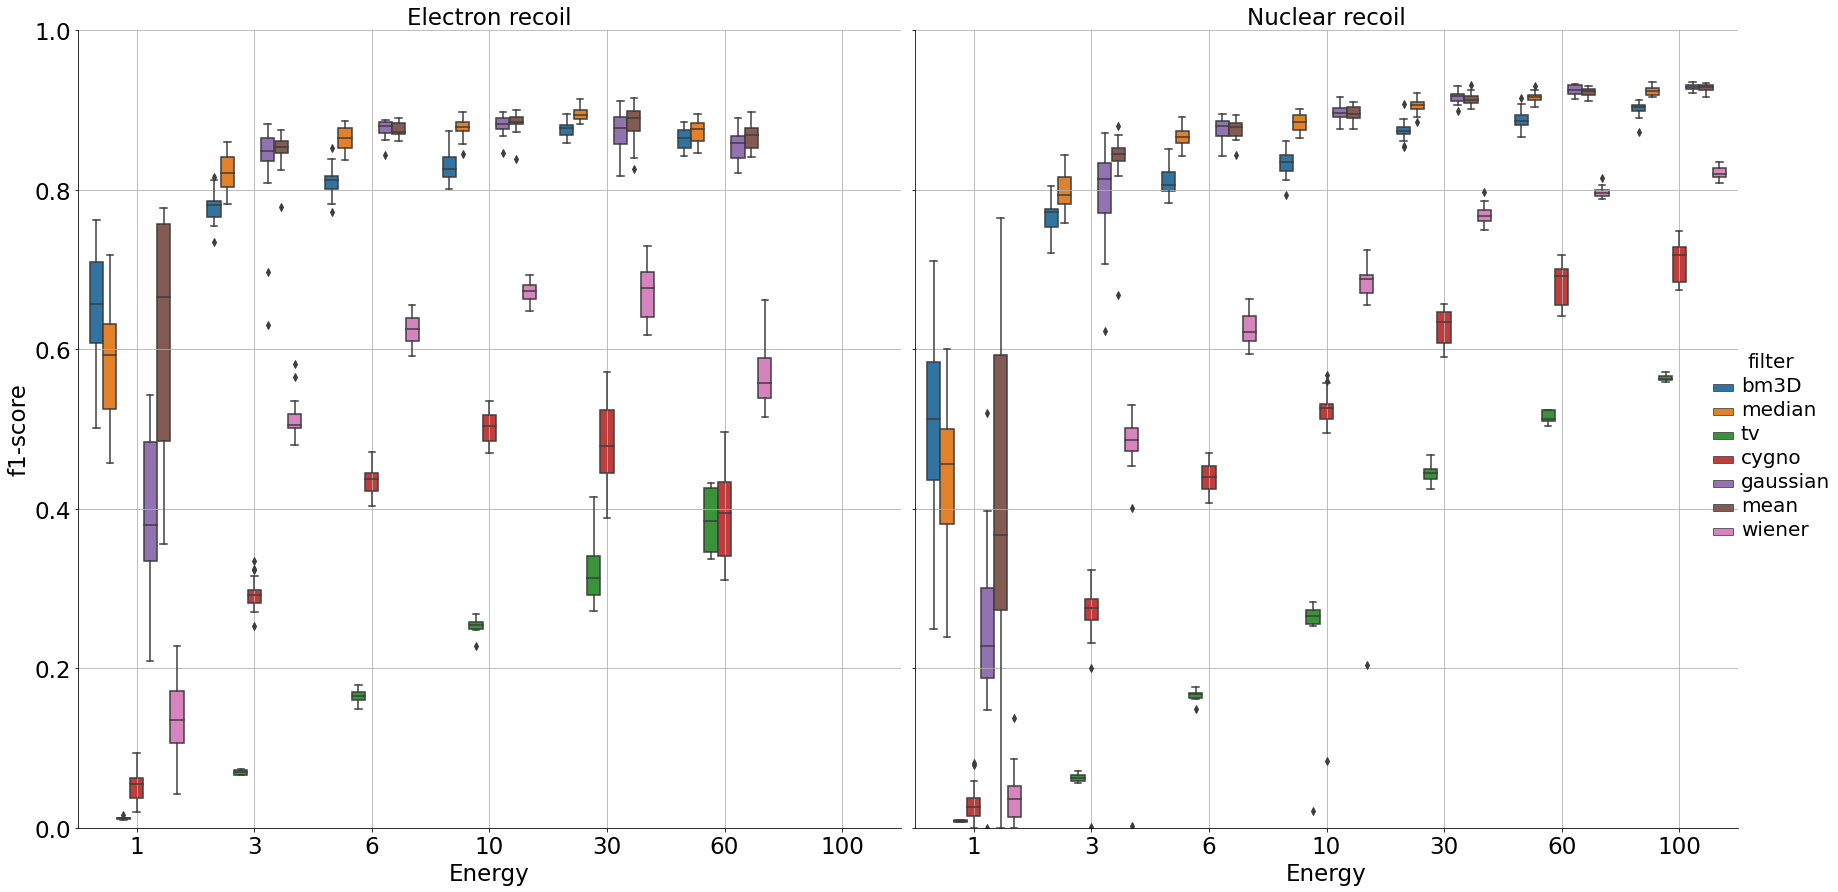

In [6]:
#plt.figure(figsize=(30,15))
g = sns.catplot(x="energy", y="f1", hue="filter", col="particle", data=best_filters, kind="box", height=12, aspect=1)
axes = g.axes.ravel()
axes[0].grid()
axes[1].grid()
axes[0].set_xlabel('Energy', fontsize=23)
axes[0].set_ylabel('f1-score', fontsize=23)
axes[1].set_xlabel('Energy', fontsize=23)
axes[0].tick_params(axis='both', which='major', labelsize=23)
axes[1].tick_params(axis='both', which='major', labelsize=23)
axes[0].set_ylim([0, 1])
axes[1].set_ylim([0, 1])
axes[0].set_title('Electron recoil', fontsize=23)
axes[1].set_title('Nuclear recoil', fontsize=23)

plt.setp(g._legend.get_texts(), fontsize=20)
plt.setp(g._legend.get_title(), fontsize=20)

In [7]:
threshold_precision = 0.90
result_table['recall_at_p'] = result_table.apply(lambda x: recall_from_roc(x, threshold_precision), axis=1)
result_table['energy_at_p'] = result_table.apply(lambda x: energy_from_roc(x, threshold_precision), axis=1)

In [8]:
energy_table = result_table.groupby(['particle', 'energy', 'image', 'filter']).agg({'f1':'max', 'recall_at_p': 'max', 'energy_at_p':'max', 'cluster_integral': 'max', 'energia_ped':'max'}).reset_index()

In [9]:
energy_table

,particle,energy,image,filter,f1,recall_at_p,energy_at_p,cluster_integral,energia_ped
0,ER,1,pic_run1_ev1,bm3D,0.655462,0.384977,284.869463,498.0,557.003767
1,ER,1,pic_run1_ev1,median,0.569343,0.211268,176.003860,498.0,557.003767
2,ER,1,pic_run1_ev11,tv,0.011674,0.000000,0.000000,496.0,419.426884
3,ER,1,pic_run1_ev14,bm3D,0.640884,0.488789,373.403318,499.0,495.604244
4,ER,1,pic_run1_ev14,median,0.526946,0.313901,272.693068,499.0,495.604244
...,...,...,...,...,...,...,...,...,...
1873,He,100,pic_run1_ev97,wiener,0.814875,0.710959,7156.490235,49920.0,7472.114393
1874,He,100,pic_run1_ev98,bm3D,0.894356,0.840483,49704.590128,49874.0,49821.610470
1875,He,100,pic_run1_ev98,median,0.929293,0.941019,49778.268393,49874.0,49821.610470
1876,He,100,pic_run1_ev99,cygno,0.678668,0.530239,5719.342070,49898.0,7334.597503


In [10]:
energy_table.columns = ['particle', 'energy', 'image', 'filter', 'f1', 'recall_p_value', 'recovered_energy', 'cluster_integral_truth', 'cluster_integral_after_ped']

In [11]:
data=pd.melt(energy_table[['energy', 'particle', 'cluster_integral_truth', 'cluster_integral_after_ped']], id_vars=['particle', 'energy'])
data

,particle,energy,variable,value
0,ER,1,cluster_integral_truth,498.000000
1,ER,1,cluster_integral_truth,498.000000
2,ER,1,cluster_integral_truth,496.000000
3,ER,1,cluster_integral_truth,499.000000
4,ER,1,cluster_integral_truth,499.000000
...,...,...,...,...
3751,He,100,cluster_integral_after_ped,7472.114393
3752,He,100,cluster_integral_after_ped,49821.610470
3753,He,100,cluster_integral_after_ped,49821.610470
3754,He,100,cluster_integral_after_ped,7334.597503


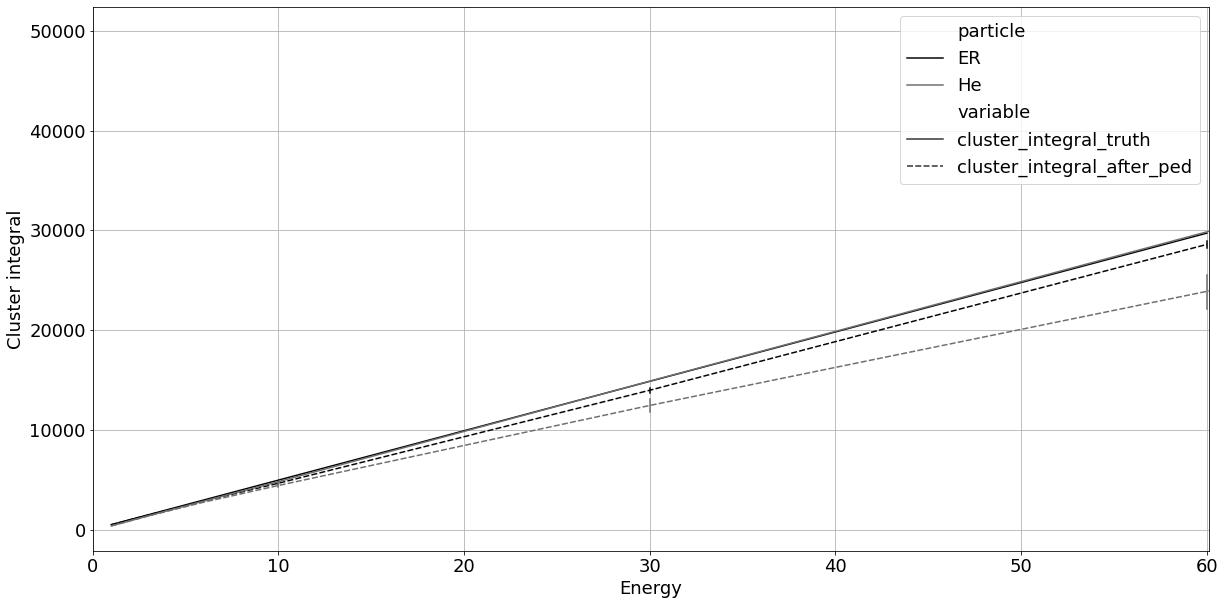

In [12]:
fig, axes = plt.subplots(1, 1, figsize=(20, 10))
#palette = sns.color_palette("mako_r", 2)
# Create an array with the colors you want to use
colors = ["#040404", "#6F6F6F"]
# Set your custom color palette
customPalette = sns.set_palette(sns.color_palette(colors))
sns.lineplot(x="energy", y="value", hue="particle", data=data,  err_style="bars", style="variable",  palette=customPalette, ax=axes)
axes.grid()
axes.set_ylabel('Cluster integral', fontsize=18)
axes.set_xlabel('Energy', fontsize=18)
axes.set_xlim([0, 60.1])
axes.tick_params(axis='both', which='major', labelsize=18)
axes.legend(fontsize=18)

In [13]:
energy_filter = energy_table[['energy', 'particle', 'filter', 'recovered_energy']]

In [14]:
energy_real = energy_table[['energy', 'particle', 'cluster_integral_after_ped']]
energy_real.columns = ['energy', 'particle', 'recovered_energy']
energy_real['filter'] = 'Energy after ped rem'

In [15]:
energy_filter = energy_filter.append(energy_real).reset_index(drop=True)

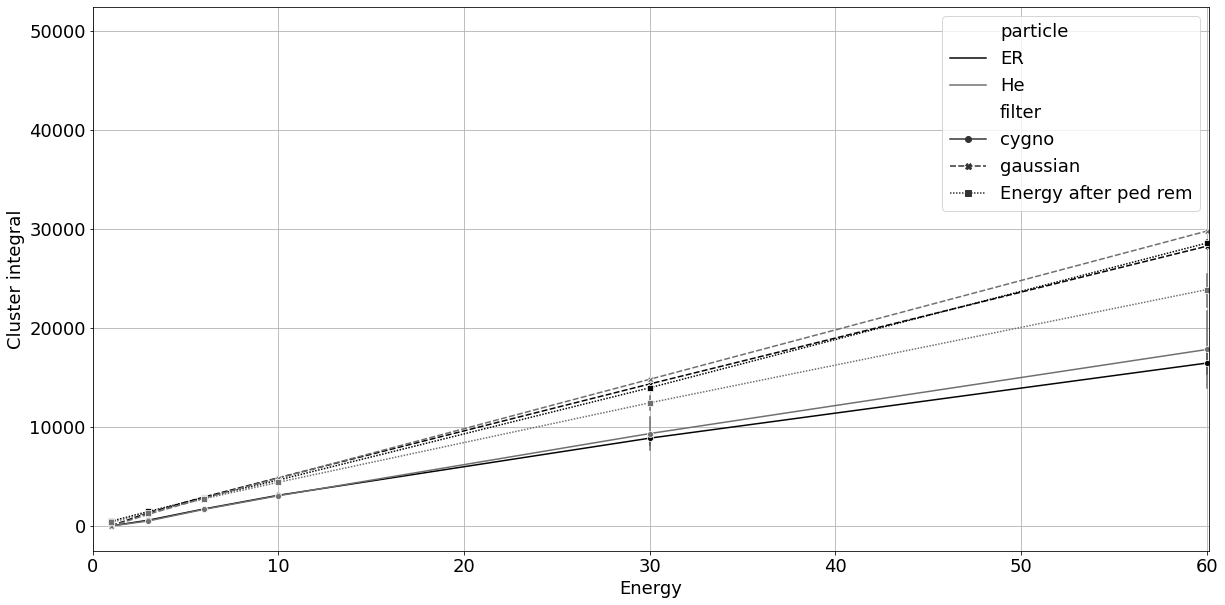

In [16]:
selec_filters = ['gaussian', 'Energy after ped rem', 'cygno']

# Create an array with the colors you want to use
colors = ["#040404", "#6F6F6F"]
# Set your custom color palette
customPalette = sns.set_palette(sns.color_palette(colors))

fig, axes = plt.subplots(1, 1, figsize=(20, 10))
#palette = sns.color_palette("hls", 2)
ax = sns.lineplot(x="energy", y="recovered_energy", hue="particle", data=energy_filter[energy_filter['filter'].isin(selec_filters)],  err_style="bars", style="filter",  palette=customPalette, markers=True,ax=axes)
axes.grid()
axes.set_ylabel('Cluster integral', fontsize=18)
axes.set_xlabel('Energy', fontsize=18)
axes.set_xlim([0, 60.1])
axes.tick_params(axis='both', which='major', labelsize=18)
axes.legend(fontsize=18)

